In [337]:
from citalopram_project.load import load_neurons, get_data_dir
import pandas as pd
import seaborn as sns
from citalopram_project.correlations import get_combs
import numpy as np
sns.set()

neurons = load_neurons().loc[lambda x: x.group.isin(["sal", "continuation"])]
df_corr = pd.read_parquet(get_data_dir() / "derived" / "pre_1s_spont_correlation_test.parquet.gzip")
df = get_combs(df_corr, neurons[["neuron_id", "cluster"]].dropna()).merge(neurons[["group", "neuron_id"]], left_on="neuron_1", right_on="neuron_id")
df["abs_val"] = df["value"].abs()
df = df.loc[lambda x: x.comb.str.contains("slow_regular")]

C:\Users\roryl\.conda\envs\citalopram\lib\site-packages\seaborn\axisgrid.py:670: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


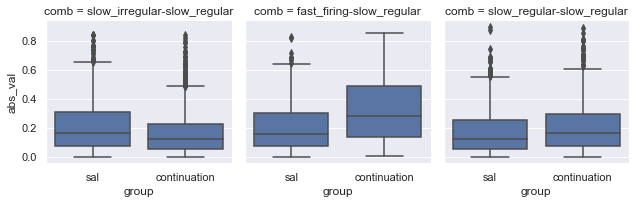

In [338]:
sns.FacetGrid(data=df, col="comb").map(sns.boxplot, "group", "abs_val")

[Text(0, 0, 'SR-SIR'), Text(1, 0, 'SR-FF'), Text(2, 0, 'SR-SR')]

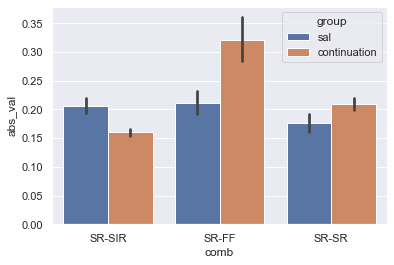

In [343]:
ax = sns.barplot(data=df, hue="group", x="comb", y="abs_val")
ax.set_xticklabels(["SR-SIR", "SR-FF", "SR-SR"])

df

In [334]:
import statsmodels.formula.api as smf

df1 = df.loc[lambda x: (x.comb == "slow_regular-slow_regular")]
mod = smf.ols("abs_val ~ group", data=df1).fit()
print(f"SR-SR {mod.conf_int().iloc[1, :].values}")

df1 = df.loc[lambda x: (x.comb == "slow_irregular-slow_regular")]
mod = smf.ols("abs_val ~ group", data=df1).fit()
print(f"SR-SIR {mod.conf_int().iloc[1, :].values}")

df1 = df.loc[lambda x: (x.comb == "fast_firing-slow_regular")]
mod = smf.ols("abs_val ~ group", data=df1).fit()
print(f"SR-FF {mod.conf_int().iloc[1, :].values}")

SR-SR [-0.05181886 -0.01397842]
SR-SIR [0.03303178 0.05818813]
SR-FF [-0.15006566 -0.06797219]


In [141]:
from spiketimes.utils import p_adjust

df_stats = pd.read_parquet(get_data_dir() / "derived" / "spont_ensemble_stats.parquet.gzip")
df = df_stats.merge(neurons[["session_name", "group"]].drop_duplicates()).assign(pval_sig=lambda x: p_adjust(x.score_pval) < 0.05).loc[lambda x: x.group.isin(["sal", "continuation"])]

df[["sig"]] = (df["pval_sig"]) & (df["simmilarity"] > 0.1)

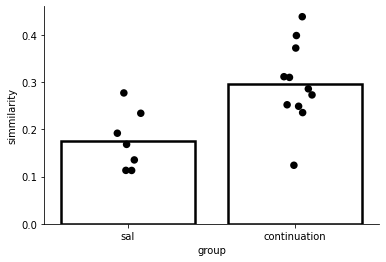

In [142]:
sns.barplot(data=df.loc[lambda x: x.sig == True], x="group", y="simmilarity", ci=None, edgecolor="black", fc="none", linewidth=2.5)
sns.stripplot(data=df.loc[lambda x: x.sig == True], x="group", y="simmilarity", color="black", linewidth=2.5)
sns.despine()

In [143]:
nums = df.loc[lambda x: x.simmilarity > 0.2].groupby("session_name", as_index=False).apply(lambda x: x.ensemble_id.nunique())
num_ensembles = df[["session_name", "group"]].drop_duplicates().merge(nums, how="left").fillna(0).rename(columns={None: "num_ensembles"})

mod = smf.ols("num_ensembles ~ group", data=num_ensembles).fit()
table = sm.stats.anova_lm(mod, typ=3)
table

,sum_sq,df,F,PR(>F)
Intercept,14.285714,1.0,27.272727,0.000547
group,2.194805,1.0,4.190083,0.070961
Residual,4.714286,9.0,NaN,NaN


In [145]:
df1 = df.loc[lambda x: x.sig == True]
pairwise_tukeyhsd(df1["simmilarity"], df1["group"]).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
continuation,sal,-0.1195,0.0063,-0.2001,-0.039,True


In [146]:
nums = df.loc[lambda x: x.sig == True].groupby("session_name", as_index=False).apply(lambda x: x.ensemble_id.nunique())

num_ensembles = df[["session_name", "group"]].drop_duplicates().merge(nums, how="left").fillna(0).rename(columns={None: "num_ensembles"})


mod = smf.ols("num_ensembles ~ group", data=num_ensembles).fit()
table = sm.stats.anova_lm(mod, typ=3)
table

,sum_sq,df,F,PR(>F)
Intercept,17.285714,1.0,24.066298,0.000841
group,0.081169,1.0,0.113009,0.744450
Residual,6.464286,9.0,NaN,NaN


In [149]:
num_ensembles

,session_name,group,num_ensembles
0,hamilton_01,sal,1
1,hamilton_02,continuation,1
2,hamilton_13,sal,1
3,hamilton_14,continuation,1
4,hamilton_23,continuation,1
5,hamilton_07,sal,3
6,hamilton_08,continuation,3
7,hamilton_19,sal,2
8,hamilton_20,continuation,2
9,chronic_08,continuation,1


In [151]:
num_ensembles = df[["session_name", "group"]].drop_duplicates()
num_ensembles

,session_name,group
0,hamilton_01,sal
2,hamilton_02,continuation
6,hamilton_13,sal
10,hamilton_14,continuation
20,hamilton_23,continuation
22,hamilton_07,sal
25,hamilton_08,continuation
29,hamilton_19,sal
31,hamilton_20,continuation
48,chronic_08,continuation


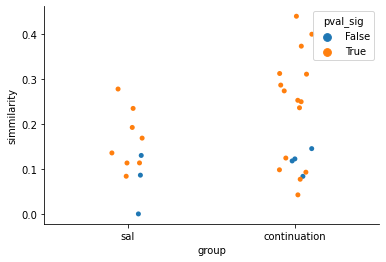

In [124]:
# df["score_sig"] =df["score_pval"] < 0.05

sns.stripplot(data=df, x="group", y="simmilarity", hue="pval_sig")
sns.despine()

In [ ]:

sns.barplot(data=prop, x="group", y="proportion", color="black")
sns.despine()


In [89]:
# relative proportion of ensembles?
# num ensembles / num recordings

num_recordings = neurons.groupby("group", as_index=False).apply(lambda x: x["session_name"].nunique()).rename(columns={None: "num_recordings"})
num_ensembles = df.loc[lambda x: x.pval_sig ==True].groupby("group", as_index=False).apply(lambda x: len(x)).rename(columns={None: "num_ensembles"})

prop = num_recordings.merge(num_ensembles)
prop["proportion"] = prop["num_ensembles"].divide(prop["num_recordings"])
prop

,group,num_recordings,num_ensembles,proportion
0,continuation,7,15,2.142857
1,discontinuation,9,13,1.444444
2,sal,5,8,1.600000


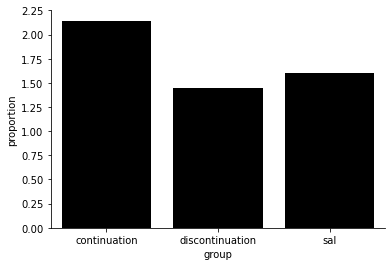

In [69]:
sns.barplot(data=prop, x="group", y="proportion", color="black")
sns.despine()


# model 

#   pval_sig ~ group
#   ensembles_in_session ~ group

In [42]:
df.loc[lambda x: x.pval_sig == True].groupby("group", as_index=False).apply(lambda x: x.simmilarity.mean())

,group,NaN
0,continuation,0.237588
1,discontinuation,0.148332
2,sal,0.164716


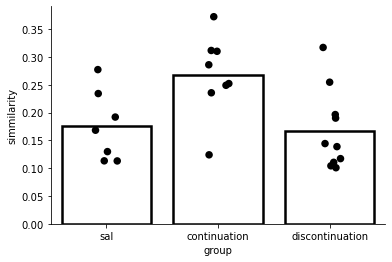

In [99]:

sns.barplot(data=df.loc[lambda x: x.ensemble_sig == True], x="group", y="simmilarity", ci=None, edgecolor="black", fc="none", linewidth=2.5)
sns.stripplot(data=df.loc[lambda x: x.ensemble_sig == True], x="group", y="simmilarity", color="black", linewidth=2.5)
sns.despine()



In [80]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd


mod = smf.ols("simmilarity ~ group", data=df.loc[lambda x: x.ensemble_sig == True]).fit()
table = sm.stats.anova_lm(mod, typ=3)
table

,sum_sq,df,F,PR(>F)
Intercept,0.573764,1.0,116.541348,2.946212e-10
group,0.051450,2.0,5.225162,1.390721e-02
Residual,0.108312,22.0,NaN,NaN


In [78]:
df1 = df.loc[lambda x: x.ensemble_sig == True]
pairwise_tukeyhsd(df1["simmilarity"], df1["group"]).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
continuation,discontinuation,-0.1003,0.0169,-0.1839,-0.0167,True
continuation,sal,-0.0923,0.0469,-0.1835,-0.0011,True
discontinuation,sal,0.008,0.9,-0.0789,0.0948,False


<AxesSubplot:xlabel='group', ylabel='simmilarity'>

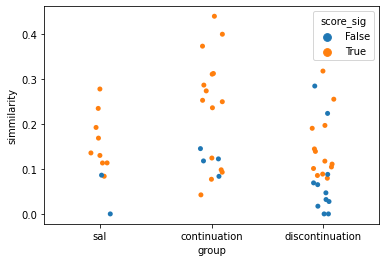

In [117]:
df["score_sig"] =df["score_pval"] < 0.05

sns.stripplot(data=df, x="group", y="simmilarity", hue="score_sig")

In [93]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd


mod = smf.ols("size ~ group", data=df.loc[lambda x: x.ensemble_sig == True]).fit()
table = sm.stats.anova_lm(mod, typ=3)
table

df1 = df.loc[lambda x: x.ensemble_sig == True]
pairwise_tukeyhsd(df1["size"], df1["group"]).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
continuation,discontinuation,-5.575,0.2281,-13.8162,2.6662,False
continuation,sal,3.3393,0.6198,-5.6526,12.3312,False
discontinuation,sal,8.9143,0.0403,0.3523,17.4763,True


<AxesSubplot:xlabel='group', ylabel='size'>

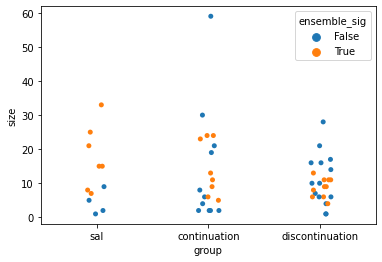

In [94]:
sns.stripplot(data=df, x="group", y="size", hue="ensemble_sig")

In [113]:


nums = df.loc[lambda x: x.simmilarity > 0.2].groupby("session_name", as_index=False).apply(lambda x: x.ensemble_id.nunique())

num_ensembles = neurons[["session_name", "group"]].drop_duplicates().merge(nums, how="left").fillna(0).rename(columns={None: "num_ensembles"})


mod = smf.ols("num_ensembles ~ group", data=num_ensembles).fit()
table = sm.stats.anova_lm(mod, typ=3)
table

,sum_sq,df,F,PR(>F)
Intercept,14.285714,1.0,28.144545,0.000048
group,4.673016,2.0,4.603197,0.024289
Residual,9.136508,18.0,NaN,NaN


<AxesSubplot:xlabel='group', ylabel='num_ensembles'>

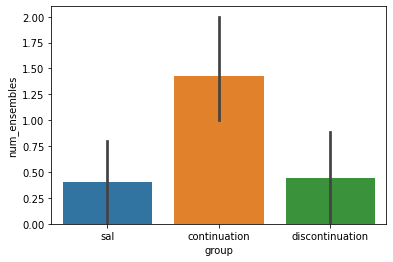

In [114]:
sns.barplot(x="group", y="num_ensembles", data=num_ensembles)